In [1]:
import PIL
import numpy as np
import torch
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import open3d
import scipy.spatial.transform as transform
import meshcat
import meshcat.geometry as g
from collections import defaultdict
import meshcat.transformations as tf
from scipy.spatial.transform import Rotation as R
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Simple Object Detection on 1 Image with YOLO

In [2]:
def get_color(idx):
    idx = idx * 3
    color = ((37 * idx) % 255, (17 * idx) % 255, (29 * idx) % 255)
    return color

In [102]:
np.linalg.inv(img_to_lidar_transform)

array([[          0,           0,           1,       0.186],
       [         -1,          -0,          -0,       0.045],
       [         -0,          -1,          -0,       -0.03],
       [          0,           0,           0,           1]])

In [91]:
n = 47
root = '/media/shashank/T/processed/go2nus/utown_new_1_2025-04-29_11-16-17_10_merged_0/'
sample_image_path = os.path.join(root,'imgs',f'{n}.jpg')
sample_image = np.asarray(PIL.Image.open(sample_image_path))
sample_pcd_path = os.path.join(root,'pcd',f'{n}.npz')
sample_pcd = np.load(sample_pcd_path)['arr_0']
img_to_lidar_transform = np.eye(4)
quat = np.array([-0.5,0.5,-0.5,-0.5])#np.array([-0.512, 0.512, -0.487, 0.487])
trans = np.array([0.045,-0.03,-0.186])#np.array([0.150, 0.060, 0.015])
img_to_lidar_transform[:3,:3] = transform.Rotation.from_quat(quat).as_matrix()
img_to_lidar_transform[:3,-1] = trans
#lidar_to_img_transform = np.linalg.inv(img_to_lidar_transform)
lidar_to_img_trans = np.array([
      -0.0015738598192886486,
      0.03991416645243864,
      0.012297185596946132])
lidar_to_img_rot = np.array([-0.48524342032298623,
      0.5010225052529601,
      -0.493118455572368,
      0.5199514025726053])
lidar_to_img_transform =  np.eye(4)
lidar_to_img_transform[:3,:3] = transform.Rotation.from_quat(lidar_to_img_rot).as_matrix()
lidar_to_img_transform[:3,-1] = lidar_to_img_trans
#add pitch
#lidar_to_img_transform[:3,:3] = lidar_to_img_transform[:3,:3]
K = np.array([607.6533813476562, 0.0, 420.5920104980469,
              0.0,          607.3688354492188, 247.97695922851562,
              0.0,              0.0,                1.0]).reshape(3,3)
fx = K[0,0]
fy = K[1,1]
cx = K[0,2]
cy = K[1,2]

In [92]:
sample_pcd = sample_pcd[(np.linalg.norm(sample_pcd,axis=1)<10) & (np.linalg.norm(sample_pcd,axis=1)>0.5)]

In [93]:
model = YOLO('yolo11s.pt')

In [94]:
sample_result = model(sample_image_path,classes=0)
#extract bounding box and confidence for each person detected
boxes = []
for box in sample_result[0].boxes:
    if box.cls.int() == 0:
        boxes.append((box.xyxy.cpu().numpy()[0],box.conf.cpu().numpy()))


image 1/1 /media/shashank/T/processed/go2nus/utown_new_1_2025-04-29_11-16-17_10_merged_0/imgs/47.jpg: 384x640 6 persons, 2.6ms
Speed: 0.7ms preprocess, 2.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


0.914182186126709:22.271820644162737
0.6557418704032898:0.9874044574281704
0.5134832262992859:1.092541532696418
0.45034757256507874:0.4861710206517633
0.4143713414669037:0.09876800033281434
0.3389495015144348:0.1879662387775925


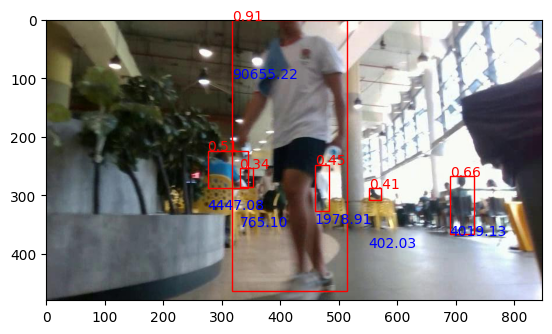

In [95]:
#plot the bounding boxes in boxes in the same image
fig, ax = plt.subplots()
ax.imshow(sample_image)
for box,conf in boxes:
    x1,y1,x2,y2 = box
    ax.add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none'))
    ax.text(x1,y1,f'{conf[0]:.2f}',color='r')
    ax.text(x1,y1+100,f'{(y2-y1)*(x2-x1):.2f}',color='b')
    print(f'{conf[0]}:{(y2-y1)*(x2-x1)*100.0/(sample_image.shape[0]*sample_image.shape[1])}')

### Finding the detected objects in the LiDAR

In [96]:
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [97]:
vis.delete()

In [98]:
#add a pitch to the lidar
def add_pitch(points, pitch):
    # Create a rotation matrix for the pitch angle
    rotation_matrix = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    # Apply the rotation to the points
    rotated_points = points @ rotation_matrix.T
    return rotated_points
sample_pcd_pitched = add_pitch(sample_pcd, np.deg2rad(0))

In [99]:
vis[f'detections/all_{n}'].set_object(
    g.PointsGeometry(
        np.array(sample_pcd.T),#cl.points).T,
        color=np.zeros_like(sample_pcd).T,
    ),
    g.PointsMaterial(size=0.05)
)
c = np.zeros_like(sample_pcd_pitched).T
c[1,:] = 1
vis[f'detections/all_{n}_pitched'].set_object(
    g.PointsGeometry(
        np.array(sample_pcd_pitched.T),#cl.points).T,
        color=c,
    ),
    g.PointsMaterial(size=0.05)
)

In [100]:
def project_lidar_to_image(lidar_points, lidar_to_rgb_transform, camera_intrinsics, img_height, img_width):
    """
    
    Projects 3D LiDAR points onto an RGB image.

    Args:
        lidar_points (np.ndarray): Nx3 array of 3D LiDAR points.
        lidar_to_rgb_transform (np.ndarray): 4x4 matrix transforming LiDAR to camera frame.
        camera_intrinsics (np.ndarray): 3x3 intrinsic camera matrix.

    Returns:
        np.ndarray: Depth image with projected depth values at corresponding pixel locations.
        np.ndarray: 2D pixel coordinates of the valid LiDAR points.
    """
    # Step 1: Convert LiDAR points to homogeneous coordinates
    ones = np.ones((lidar_points.shape[0], 1))
    lidar_points_hom = np.hstack((lidar_points, ones))  # Nx4
    
    # Step 2: Transform to the camera frame
    camera_points_hom = (lidar_to_rgb_transform @ lidar_points_hom.T).T  # Nx4
    
    # Step 3: Normalize to 3D (remove homogeneous component)
    camera_points = camera_points_hom[:, :3] / camera_points_hom[:, 3, np.newaxis]  # Nx3
    
    # Step 4: Project to the 2D image plane using intrinsic matrix
    pixels_hom = (camera_intrinsics @ camera_points.T).T  # Nx3
    pixels = pixels_hom[:, :2] / pixels_hom[:, 2, np.newaxis]  # Nx2
    
    # Step 5: Filter points with positive depth and within image bounds
    valid_mask = (
        (camera_points[:, 2] > 0) &  # Positive depth
        (pixels[:, 0] >= 0) & (pixels[:, 0] < img_width) &  # x within img_width
        (pixels[:, 1] >= 0) & (pixels[:, 1] < img_height)  # y within img_height
    )
    
    valid_pixels = pixels[valid_mask].astype(int)
    valid_depths = camera_points[valid_mask, 2]
    
    # Step 6: Create a depth image and populate it
    depth_image = np.zeros((img_height, img_width), dtype=np.float32)
    depth_image[valid_pixels[:, 1], valid_pixels[:, 0]] = valid_depths
    return depth_image, valid_pixels

def generate_point_cloud(depth, 
                         fx,fy,cx,cy,
                         z_min=0,
                         z_max=1.0,
                         z_filter=np.inf,
                         z_scale=1.0):
    
    height,width = depth.shape
    if cx == 0 and cy == 0:
        cx = width / 2
        cy = height / 2

    # Generate mesh grid and calculate point cloud coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    x = (x - cx) / fx
    y = (y - cy) / fy
    z = z_min + depth * (z_max - z_min) / z_scale
    pimg = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1)
    points_flattened = pimg.reshape(-1, 3)
    points_flattened = points_flattened[z.flatten() < z_filter]
    return points_flattened

def filter_pixels_in_bbox(valid_pixels, boxes):
    #given a list of pixels and a bounding box, filter the list to all pixels within each bounding box
    valid_pixels_in_bbox = []   
    for box,conf in boxes:
        x1,y1,x2,y2 = box
        valid_pixels_in_bbox.append(valid_pixels[(valid_pixels[:,0] > x1) & (valid_pixels[:,0] < x2) & (valid_pixels[:,1] > y1) & (valid_pixels[:,1] < y2)])
    return valid_pixels_in_bbox

def pixel_depth_to_3D(pixel_x,pixel_y,metric_z,cx,cy,fx,fy):
    # convert pixel x,y and metric depth (z) to 3D point
    x = np.multiply((pixel_x - cx) / fx, metric_z)
    y = np.multiply((pixel_y - cy) / fy, metric_z)
    points = np.stack((x,y,metric_z),axis=-1).reshape(-1,3)
    return points

valid pixels in bbox 0: (1752, 3)
valid pixels in bbox 1: (140, 3)
valid pixels in bbox 2: (229, 3)
valid pixels in bbox 3: (103, 3)
valid pixels in bbox 4: (22, 3)
valid pixels in bbox 5: (51, 3)


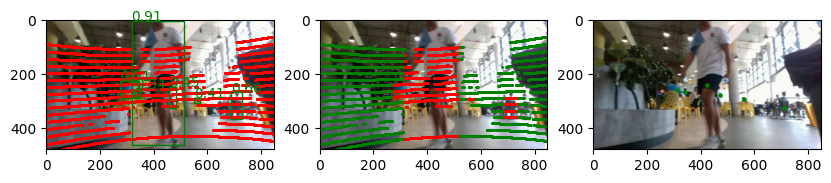

In [101]:
#depth image from LiDAR point cloud and camera intrinsics
depth_image, valid_pixels = project_lidar_to_image(sample_pcd_pitched, np.linalg.inv(lidar_to_img_transform), K, sample_image.shape[0], sample_image.shape[1])
valid_pixels_in_bbox = filter_pixels_in_bbox(valid_pixels, boxes)
for i in range(len(valid_pixels_in_bbox)):
    depth = depth_image[valid_pixels_in_bbox[i][:,1],valid_pixels_in_bbox[i][:,0]]
    valid_pixels_in_bbox[i] = np.hstack((valid_pixels_in_bbox[i],depth[:,None]))
    print(f'valid pixels in bbox {i}: {valid_pixels_in_bbox[i].shape}')
    if valid_pixels_in_bbox[i].shape[0]>0:
        reprojected_pixels = np.zeros((valid_pixels_in_bbox[i].shape[0],4))
        reprojected_pixels[:,0] = np.multiply((valid_pixels_in_bbox[i][:,0]-cx)/fx,depth)
        reprojected_pixels[:,1] = np.multiply((valid_pixels_in_bbox[i][:,1]-cy)/fy,depth)
        reprojected_pixels[:,2] = depth
        reprojected_pixels[:,3] = np.ones((valid_pixels_in_bbox[i].shape[0]))
        reprojected_pixels = (lidar_to_img_transform@reprojected_pixels.T).T[:,:3]
        # vis[f'detections/{i}'].set_object(
        #     g.PointsGeometry(
        #         np.array(reprojected_pixels.T),
        #         color=(np.ones_like(reprojected_pixels)*get_color(i)/255.0).T,
        #     ),
        #     g.PointsMaterial(size=0.055)
        # )
#convert the pixel point to 3D point:
means = []
for vb in valid_pixels_in_bbox:
    mean = np.mean(vb,axis=0)
    means.append(mean)
means = np.concatenate(means,axis=0).reshape(-1,3)
metric_means = pixel_depth_to_3D(means[:,0],means[:,1],means[:,2],cx,cy,fx,fy)
#plot the pixels valid_pixels on sample_image as points
fig,ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(sample_image)
ax[0].scatter(valid_pixels[:,0],valid_pixels[:,1],s=1,c='r')
ax[1].scatter(valid_pixels[:,0],valid_pixels[:,1],s=1,c='g')
#plot the bounding boxes
for box,conf in boxes:
    x1,y1,x2,y2 = box
    ax[0].add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='g',facecolor='none'))
    ax[0].text(x1,y1,f'{conf[0]:.2f}',color='g')
#plot pixels inside the bounding box
ax[1].imshow(sample_image)
ax[2].imshow(sample_image)
for i in range(len(valid_pixels_in_bbox)):
    ax[1].scatter(valid_pixels_in_bbox[i][:,0],valid_pixels_in_bbox[i][:,1],s=1,c='r')
    ax[2].scatter(means[i,0],means[i,1],s=5,c='g')
means = np.concatenate(means,axis=0).reshape(-1,3)

In [44]:
#check depth image to point cloud
dpcd = generate_point_cloud(depth_image, fx, fy, cx, cy)
dpcd = dpcd[(np.linalg.norm(dpcd,axis=1)>0)]
# Step 1: Convert LiDAR points to homogeneous coordinates
ones = np.ones((dpcd .shape[0], 1))
dpcd_hom  = np.hstack((dpcd, ones))  #
dpcd = (lidar_to_img_transform@dpcd_hom.T).T[:,:3]
vis[f'depth_pcd'].set_object(
            g.PointsGeometry(
                np.array(dpcd.T),
                color=(np.ones_like(dpcd)*get_color(20)/255.0).T,
            ),
            g.PointsMaterial(size=0.055)
        )

In [ ]:
# test the pitch of the camera:
pitches = [0] #np.arange(-8,2,1)
# fig,ax = plt.subplots(len(pitches),1,figsize=(5,5*len(pitches)))
sample_pcd = sample_pcd[sample_pcd[:,2]<10]
for k,pitch in enumerate(pitches):
    quat = np.array([-0.5,0.5,-0.5,-0.5])#np.array([-0.512, 0.512, -0.487, 0.487])
    trans = np.array([0.045,-0.03,-0.186])#np.array([0.150, 0.060, 0.015])
    temp_img_to_lidar_transform = np.eye(4)
    temp_img_to_lidar_transform[:3,:3] = R.from_euler('x',pitch,degrees=True).as_matrix()@transform.Rotation.from_quat(quat).as_matrix()
    temp_img_to_lidar_transform[:3,-1] = trans
    temp_lidar_to_img_transform = np.linalg.inv(temp_img_to_lidar_transform)
    #add pitch
    temp_lidar_to_img_transform[:3,:3] = temp_lidar_to_img_transform[:3,:3]
    
    #depth image from LiDAR point cloud and camera intrinsics
    depth_image, valid_pixels = project_lidar_to_image(sample_pcd, np.linalg.inv(temp_lidar_to_img_transform), K, sample_image.shape[0], sample_image.shape[1])
    valid_pixels_in_bbox = filter_pixels_in_bbox(valid_pixels, boxes)
    for i in range(len(valid_pixels_in_bbox)):
        depth = depth_image[valid_pixels_in_bbox[i][:,1],valid_pixels_in_bbox[i][:,0]]
        valid_pixels_in_bbox[i] = np.hstack((valid_pixels_in_bbox[i],depth[:,None]))
        #print(f'valid pixels in bbox {i}: {valid_pixels_in_bbox[i].shape}')
        if valid_pixels_in_bbox[i].shape[0]>0:
            reprojected_pixels = np.zeros((valid_pixels_in_bbox[i].shape[0],4))
            reprojected_pixels[:,0] = np.multiply((valid_pixels_in_bbox[i][:,0]-cx)/fx,depth)
            reprojected_pixels[:,1] = np.multiply((valid_pixels_in_bbox[i][:,1]-cy)/fy,depth)
            reprojected_pixels[:,2] = depth
            reprojected_pixels[:,3] = np.ones((valid_pixels_in_bbox[i].shape[0]))
            reprojected_pixels = (temp_lidar_to_img_transform@reprojected_pixels.T).T[:,:3]
    #convert the pixel point to 3D point:
    means = []
    for vb in valid_pixels_in_bbox:
        mean = np.mean(vb,axis=0)
        means.append(mean)
    means = np.concatenate(means,axis=0).reshape(-1,3)
    metric_means = pixel_depth_to_3D(means[:,0],means[:,1],means[:,2],cx,cy,fx,fy)
    #plot the pixels valid_pixels on sample_image as points
    # ax[k].imshow(sample_image)
    # ax[k].scatter(valid_pixels[:,0],valid_pixels[:,1],s=0.1,c='r')
    # ax[k].text(0,-10,f'pitch: {pitch}',color='r')
    # for j in range(len(valid_pixels_in_bbox)):
    #     ax[k].scatter(valid_pixels_in_bbox[j][:,0],valid_pixels_in_bbox[j][:,1],s=0.1,c='g')

## Track objects in 3D by fusing Image and LiDAR

In [ ]:
vis.delete()
vis[f'scene/{i}'].set_object(
            g.PointsGeometry(
                sample_pcd.T,
                color = np.zeros_like(sample_pcd.T),  
            ),
            g.PointsMaterial(size=0.05)
        )


In [ ]:
vis.delete()
# Track objects in a sequence of images
start = 21
end = 25
track_history = defaultdict(lambda: [])
image_sequence = [np.asarray(PIL.Image.open(os.path.join(root,'imgs',f'{i}.jpg'))) for i in range(start,end)]
pcd_sequence = [np.load(os.path.join(root,'pcd',f'{i}.npz'))['arr_0'] for i in range(start,end)]

In [ ]:
vis.delete()
i=0
# pcd_sequence = [pcd[pcd[:,0]**2+pcd[:,1]**2<100] for pcd in pcd_sequence]
#pcd_sequence = [o3d_to_np(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd)).transform(lidar_to_img_transform))[0] for pcd in pcd_raw_sequence]
fig,ax = plt.subplots(end-start,1,figsize=((end-start)*10,10))
# for i in range(end-start):
#plot image
ax[i].imshow(image_sequence[i])
result = model.track(image_sequence[i],classes=0,persist=True)
boxes = []   
for box in result[0].boxes:
    x1,y1,x2,y2 = box.xyxy.cpu().numpy()[0]
    ax[i].add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='g' if box.id is None else np.array(get_color(box.id.cpu().numpy()[0]))/255.0,facecolor='none'))
    boxes.append((box.xyxy.cpu().numpy()[0],box.conf.cpu().numpy()))

#project lidar onto rgb
depth_image, valid_pixels = project_lidar_to_image(pcd_sequence[i], np.linalg.inv(lidar_to_img_transform), K, image_sequence[i].shape[0], image_sequence[i].shape[1])
    
means = []
valid_pixels_in_bbox = filter_pixels_in_bbox(valid_pixels, boxes)
color = np.zeros_like(pcd_sequence[i].T)
color+=1.0 - (i/(end-start))*0.9
if i == 0:
    vis[f'scene/{i}'].set_object(
            g.PointsGeometry(
                pcd_sequence[i].T,
                color = color,  
            ),
            g.PointsMaterial(size=0.05)
        )
for j in range(len(valid_pixels_in_bbox)):
    depth = depth_image[valid_pixels_in_bbox[j][:,1],valid_pixels_in_bbox[j][:,0]]
    valid_pixels_in_bbox[j] = np.hstack((valid_pixels_in_bbox[j],depth[:,None]))
    mean = np.mean(valid_pixels_in_bbox[j],axis = 0)
    ax[i].scatter(mean[0],mean[1],s=5,c='r')
    if valid_pixels_in_bbox[j].shape[0] > 0:
        #re-project valid pixels to 3D coordinates
        reprojected_pixels = np.zeros((valid_pixels_in_bbox[j].shape[0],4))
        reprojected_pixels[:,0] = np.multiply((valid_pixels_in_bbox[j][:,0]-cx)/fx,depth)
        reprojected_pixels[:,1] = np.multiply((valid_pixels_in_bbox[j][:,1]-cy)/fy,depth)
        reprojected_pixels[:,2] = depth
        reprojected_pixels[:,3] = np.ones((valid_pixels_in_bbox[j].shape[0]))
        #convert back to lidar frame
        reprojected_pixels = (lidar_to_img_transform@reprojected_pixels.T).T[:,:3]
        detection_color = np.zeros((reprojected_pixels.shape[0],3))
        detection_color+=(0,1.0,0.0) if result[0].boxes[j].id is None else np.array(get_color(result[0].boxes[j].id.cpu().numpy()[0]))/255.0            
        #pc = open3d.geometry.PointCloud()
        #pc.points = open3d.utility.Vector3dVector(reprojected_pixels)      
        #cl, ind = pc.remove_statistical_outlier(nb_neighbors=int(reprojected_pixels.shape[0]), std_ratio=0.05)
        #show the downsampled point cloud in meshcat   
        vis[f'detections/scene{i}/{j}'].set_object(
            g.PointsGeometry(
                np.array(reprojected_pixels.T),#cl.points).T,
                color=detection_color.T
            ),
            g.PointsMaterial(size=0.1)
        )
            

In [ ]:
valid_pixels_in_bbox

### Bounding Box -> All points within bounding box -> Average of all lidar pcd depths

In [ ]:
vis.delete()
#improve point filtration
#filter points within a circle of radius of 10m
pcd_sequence = [pcd[pcd[:,0]**2+pcd[:,1]**2<100] for pcd in pcd_sequence]
#pcd_sequence = [o3d_to_np(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd)).transform(lidar_to_img_transform))[0] for pcd in pcd_raw_sequence]
fig,ax = plt.subplots(1,end-start,figsize=((end-start)*10,10))
i=0
#plot image
ax[i].imshow(image_sequence[i])
result = model.track(image_sequence[i],classes=0,persist=True)

boxes = []   
for box in result[0].boxes:
    x1,y1,x2,y2 = box.xyxy.cpu().numpy()[0]
    ax[i].add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='g',facecolor='none'))
    boxes.append((box.xyxy.cpu().numpy()[0],box.conf.cpu().numpy()))

#project lidar onto rgb
depth_image, valid_pixels = project_lidar_to_image(pcd_sequence[i], np.linalg.inv(lidar_to_img_transform), K, image_sequence[i].shape[0], image_sequence[i].shape[1])
    
means = []
valid_pixels_in_bbox = filter_pixels_in_bbox(valid_pixels, boxes)
color = np.zeros_like(pcd_sequence[i].T)
color+=1.0 - (i/(end-start))*0.9
vis[f'scene/{i}'].set_object(
        g.PointsGeometry(
            pcd_sequence[i].T,
            color = color,
            
        ),
        g.PointsMaterial(size=0.05)
    )
for j in range(len(valid_pixels_in_bbox)):
    depth = depth_image[valid_pixels_in_bbox[j][:,1],valid_pixels_in_bbox[j][:,0]]
    valid_pixels_in_bbox[j] = np.hstack((valid_pixels_in_bbox[j],depth[:,None]))
    mean = np.mean(valid_pixels_in_bbox[j],axis = 0)
    ax[i].scatter(mean[0],mean[1],s=5,c='r')
    
    #re-project valid pixels to 3D coordinates
    reprojected_pixels = np.zeros((valid_pixels_in_bbox[j].shape[0],4))
    reprojected_pixels[:,0] = np.multiply((valid_pixels_in_bbox[j][:,0]-cx)/fx,depth)
    reprojected_pixels[:,1] = np.multiply((valid_pixels_in_bbox[j][:,1]-cy)/fy,depth)
    reprojected_pixels[:,2] = depth
    reprojected_pixels[:,3] = np.ones((valid_pixels_in_bbox[j].shape[0]))
    #convert back to lidar frame
    reprojected_pixels = (lidar_to_img_transform@reprojected_pixels.T).T[:,:3]
    detection_color = np.zeros((reprojected_pixels.shape[0],3))
    #set a random color for each detection
    detection_color[:, 0] = np.random.rand()
    detection_color[:, 1] = np.random.rand()
    detection_color[:, 2] = np.random.rand()
    vis[f'detections/scene{i}/{j}'].set_object(
        g.PointsGeometry(
            reprojected_pixels.T,
            color=detection_color.T
        ),
        g.PointsMaterial(size=0.1)
    )
    # pc = open3d.geometry.PointCloud()
    # pc.points = open3d.utility.Vector3dVector(reprojected_pixels)      
    # #cl,ind = pc.remove_radius_outlier(nb_points=5,radius=0.1)
    # cl, ind = pc.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    # #show the downsampled point cloud in meshcat
    # vis[f'detections/scene{i}/{j}_filtered'].set_object(
    #     g.PointsGeometry(
    #         np.asarray(cl.points).T,
    #         color=detection_color.T
    #     ),
    #     g.PointsMaterial(size=0.1)
    # )      

### Center of bounding box -> all points x distance from the center of the bounding box -> average of these lidar points

In [ ]:
def filter_pixels_in_bbox_centdist(valid_pixels, boxes,dist_theshold_ratio = 1.0):
    #given a list of pixels and a bounding box, filter the list to all pixels within each bounding box that are within an input distance of the center of the bounding box
    valid_pixels_in_bbox = []
    for box, conf in boxes:
        x1, y1, x2, y2 = box
        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
        filtered_pixels = valid_pixels[
            (valid_pixels[:, 0] > x1) & (valid_pixels[:, 0] < x2) &
            (valid_pixels[:, 1] > y1) & (valid_pixels[:, 1] < y2)
        ]
        distances = np.sqrt((filtered_pixels[:, 0] - center_x) ** 2 + (filtered_pixels[:, 1] - center_y) ** 2)
        valid_pixels_in_bbox.append(filtered_pixels[distances <= min(dist_theshold_ratio * (x2 - x1), dist_theshold_ratio * (y2 - y1))])
    return valid_pixels_in_bbox


vis.delete()
#improve point filtration
#filter points within a circle of radius of 10m
pcd_sequence = [pcd[pcd[:,0]**2+pcd[:,1]**2<100] for pcd in pcd_sequence]
#pcd_sequence = [o3d_to_np(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd)).transform(lidar_to_img_transform))[0] for pcd in pcd_raw_sequence]
fig,ax = plt.subplots(1,end-start,figsize=((end-start)*10,10))
i=0
#plot image
ax[i].imshow(image_sequence[i])
result = model.track(image_sequence[i],classes=0,persist=True)

boxes = []   
for box in result[0].boxes:
    x1,y1,x2,y2 = box.xyxy.cpu().numpy()[0]
    ax[i].add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='g',facecolor='none'))
    boxes.append((box.xyxy.cpu().numpy()[0],box.conf.cpu().numpy()))
    ax[i].text(x1, y1, f'{conf[0]:.2f}', color='g')

#project lidar onto rgb
depth_image, valid_pixels = project_lidar_to_image(pcd_sequence[i], np.linalg.inv(lidar_to_img_transform), K, image_sequence[i].shape[0], image_sequence[i].shape[1])
    
means = []
valid_pixels_in_bbox = filter_pixels_in_bbox_centdist(valid_pixels, boxes,1.0)

color = np.zeros_like(pcd_sequence[i].T)
color+=1.0 - (i/(end-start))*0.9
vis[f'scene/{i}'].set_object(
        g.PointsGeometry(
            pcd_sequence[i].T,
            color = color,
        ),
        g.PointsMaterial(size=0.05)
    )
for j in range(len(valid_pixels_in_bbox)):
    depth = depth_image[valid_pixels_in_bbox[j][:,1],valid_pixels_in_bbox[j][:,0]]
    valid_pixels_in_bbox[j] = np.hstack((valid_pixels_in_bbox[j],depth[:,None]))
    mean = np.mean(valid_pixels_in_bbox[j],axis = 0)
    ax[i].scatter(mean[0],mean[1],s=5,c='r')
    
    #re-project valid pixels to 3D coordinates
    reprojected_pixels = np.zeros((valid_pixels_in_bbox[j].shape[0],4))
    reprojected_pixels[:,0] = np.multiply((valid_pixels_in_bbox[j][:,0]-cx)/fx,depth)
    reprojected_pixels[:,1] = np.multiply((valid_pixels_in_bbox[j][:,1]-cy)/fy,depth)
    reprojected_pixels[:,2] = depth
    reprojected_pixels[:,3] = np.ones((valid_pixels_in_bbox[j].shape[0]))
    #convert back to lidar frame
    reprojected_pixels = (lidar_to_img_transform@reprojected_pixels.T).T[:,:3]
    detection_color = np.zeros((reprojected_pixels.shape[0],3))
    #set a random color for each detection
    detection_color[:, 0] = np.random.rand()
    detection_color[:, 1] = np.random.rand()
    detection_color[:, 2] = np.random.rand()
    # vis[f'detections/scene{i}/{j}'].set_object(
    #     g.PointsGeometry(
    #         reprojected_pixels.T,
    #         color=detection_color.T
    #     ),
    #     g.PointsMaterial(size=0.1)
    # )
    pc = open3d.geometry.PointCloud()
    pc.points = open3d.utility.Vector3dVector(reprojected_pixels)      
    #cl,ind = pc.remove_radius_outlier(nb_points=5,radius=0.05)
    cl, ind = pc.remove_statistical_outlier(nb_neighbors=int(reprojected_pixels.shape[0]*1.0), std_ratio=0.5)
    #show the downsampled point cloud in meshcat
    vis[f'detections/scene{i}/{j}_filtered'].set_object(
        g.PointsGeometry(
            np.asarray(cl.points).T,
            color=detection_color.T
        ),
        g.PointsMaterial(size=0.1)
    )      

In [ ]:
verts = np.random.random((3, 100000)).astype(np.float32)
colors = np.zeros_like(verts)
colors[0,:] = 1.0
vis.set_object(g.Points(
    g.PointsGeometry(verts, color=colors),
    g.PointsMaterial()
))

In [ ]:

vis.set_object(
    g.PointsGeometry(
        pcd_sequence[0].T,
    ),
    g.PointsMaterial()
)

### Fuse Camera and LiDAR to get depths corresponding to LiDAR points within the Bounding box pixels

In [ ]:
fig,ax = plt.subplots(1,end-start,figsize=((end-start)*10,10))
filtered_valid_pixels=[]
for i in range(end-start):
    ax[i].imshow(image_sequence[i])
    depth_image, valid_pixels = project_lidar_to_image(pcd_sequence[i], np.linalg.inv(lidar_to_img_transform), K, image_sequence[i].shape[0], image_sequence[i].shape[1])
    sample_result = model.track(image_sequence[i], persist=True,classes=0)
    boxes = []
    for box in sample_result[0].boxes:
        boxes.append((box.xyxy.cpu().numpy()[0],box.conf.cpu().numpy()))
        x1,y1,x2,y2 = box.xyxy.cpu().numpy()[0]
        ax[i].add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='g',facecolor='none'))
    
    valid_pixels_in_bbox = filter_pixels_in_bbox(valid_pixels, boxes)
    for j in range(len(valid_pixels_in_bbox)):
        depth = depth_image[valid_pixels_in_bbox[j][:,1],valid_pixels_in_bbox[j][:,0]]
        valid_pixels_in_bbox[j] = np.hstack((valid_pixels_in_bbox[j],depth[:,None]))
        ax[i].scatter(valid_pixels_in_bbox[j][:,0],valid_pixels_in_bbox[j][:,1],s=1,c='r')
    filtered_valid_pixels.append(valid_pixels_in_bbox) #pixel_x,pixel_y,metric_depth

### Visualize the filtered point cloud in meshcat

In [ ]:
# For each frame, extract the metric-x-y-z coordinates from the depth 
filtered_points = []
filtered_points_3D = []
for i in range(end-start):
    points_3d = []
    for detection in filtered_valid_pixels[i]:
        #convert the pixel x and y to metric
        metric_points = pixel_depth_to_3D(detection[:,0],detection[:,1],detection[:,2],cx,cy,fx,fy)
        points_3d.append(metric_points)        
    filtered_points_3D.append(points_3d)

In [ ]:
scene_points = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd_sequence[0]))
scene_points.transform(lidar_to_img_transform)
vis['scene_0'].set_object(
    g.PointsGeometry(
        o3d_to_np(scene_points)[0].T,
    ),
    g.PointsMaterial()
)

In [ ]:
filtered_points_3D[0][0].shape

In [ ]:
# For each frame, visualize the 3D points in meshcat
#for i in range(start,end):
for i,d in enumerate(filtered_points_3D[0]):
    vis[f'detection_{i}'].set_object(
        g.PointsGeometry(
            d.transpose(0,1).T,
        ),
        g.PointsMaterial()
    )

In [ ]:
vis_pcd(vis,name=f'scene',pts=pcd_sequence[0],sizep=0.01)    

## 3D Detection with MM3Detect

In [ ]:
!mim download mmdet3d --config pointpillars_hv_secfpn_8xb6-160e_kitti-3d-3class --dest .

In [ ]:
from mmdet3d.apis import init_model, inference_detector
config_file = 'pointpillars_hv_secfpn_8xb6-160e_kitti-3d-3class.py'
checkpoint_file = 'hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth'
model = init_model(config_file, checkpoint_file)

In [ ]:
i = 0
moved_pcd = pcd_sequence[i].copy()
moved_pcd[:,-1]+=0
np.hstack([moved_pcd,np.zeros((moved_pcd.shape[0],1))]).astype(np.float32).tofile('test_mm.bin')
#moved_pcd.tofile('test_mm.bin')

In [ ]:
vis_pcd(vis,'scene',pts = moved_pcd,sizep=0.01)

In [ ]:
results = inference_detector(model, 'mmdetection3d/demo/data/kitti/000008.bin')

In [ ]:
bboxes3d = results[0].pred_instances_3d.bboxes_3d
scores3d = results[0].pred_instances_3d.scores_3d
labels3d = results[0].pred_instances_3d.labels_3d

In [ ]:
dir(results[0].pred_instances_3d.bboxes_3d)

In [ ]:
labels3d

In [ ]:
colors = {
    "red": "#FF0000",
    "green": "#00FF00",
    "blue": "#0000FF",
    "yellow": "#FFFF00",
    "cyan": "#00FFFF",
    "magenta": "#FF00FF",
    "black": "#000000",
    "white": "#FFFFFF",
    "orange": "#FFA500",
    "purple": "#800080"
}

In [ ]:
for i in range(len(bboxes3d)):
    #if labels3d[i] == 6:
    dims = bboxes3d[i].dims[0].cpu().numpy()
    vis[f'bbox_3d_{i}'].set_object(
        g.Box([float(dims[0]),float(dims[1]),float(dims[2])]),
        #make the box transparent
        g.MeshLambertMaterial(color=colors[list(colors.keys())[0]], opacity=0.1)
    )
    vis[f'bbox_3d_{i}'].set_transform(tf.translation_matrix(bboxes3d[i].center.cpu().numpy()))

In [ ]:
vis.delete()

In [ ]:
a = np.fromfile('/media/dataset_access/datasets/jrdb_kitti/training/velodyne/006930.bin',dtype=np.float32).reshape(-1,4)

In [ ]:
vis_pcd(vis,'kitti',pts = a[:,:3],sizep=0.01)

In [ ]:
plt.imshow(cv2.imread('/media/dataset_access/datasets/jrdb_kitti/training/image_2/006930.jpg'))